Observation Space: Discrete(16)
Sample observation: 1
Action Space Shape: 4
Action Space Sample: 3
There are 4 possible actions


  0%|          | 0/1000 [00:00<?, ?it/s]

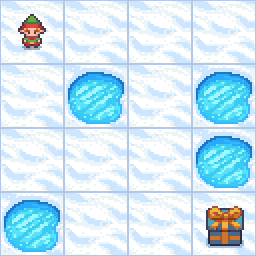

In [3]:
import numpy as np
import gym
import random
import imageio
from tqdm.notebook import trange

# Set render_mode here
env = gym.make("FrozenLake-v1", map_name="4x4", is_slippery=False, render_mode="rgb_array")
print("Observation Space:", env.observation_space)
print("Sample observation:", env.observation_space.sample())

print("Action Space Shape:", env.action_space.n)
print("Action Space Sample:", env.action_space.sample())

state_space = env.observation_space.n
action_space = env.action_space.n
print("There are", action_space, "possible actions")

def initialize_q_table(state_space, action_space):
    return np.zeros((state_space, action_space))

Qtable_frozenlake = initialize_q_table(state_space, action_space)

def epsilon_greedy_policy(Qtable, state, epsilon):
    if random.uniform(0, 1) > epsilon:
        action = np.argmax(Qtable[state])
    else:
        action = env.action_space.sample()
    return action

def greedy_policy(Qtable, state):
    return np.argmax(Qtable[state])

n_training_episodes = 1000
learning_rate = 0.7
n_eval_episodes = 100
max_steps = 99
gamma = 0.95
max_epsilon = 1.0
min_epsilon = 0.5
decay_rate = 0.0005

def train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable):
    for episode in trange(n_training_episodes):
        reset_result = env.reset()
        state = reset_result if isinstance(reset_result, int) else reset_result[0]
        epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * episode)
        for step in range(max_steps):
            action = epsilon_greedy_policy(Qtable, state, epsilon)
            step_result = env.step(action)
            if len(step_result) == 4:
                new_state, reward, done, _ = step_result
            else:
                new_state, reward, done, _, _ = step_result
            Qtable[state][action] = Qtable[state][action] + learning_rate * (
                reward + gamma * np.max(Qtable[new_state]) - Qtable[state][action]
            )
            if done:
                break
            state = new_state
    return Qtable

Qtable_frozenlake = train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable_frozenlake)

def evaluate_agent(env, max_steps, n_eval_episodes, Qtable):
    episode_rewards = []
    for episode in range(n_eval_episodes):
        reset_result = env.reset()
        state = reset_result if isinstance(reset_result, int) else reset_result[0]
        total_rewards_ep = 0
        for step in range(max_steps):
            action = np.argmax(Qtable[state])
            step_result = env.step(action)
            if len(step_result) == 4:
                new_state, reward, done, _ = step_result
            else:
                new_state, reward, done, _, _ = step_result
            total_rewards_ep += reward
            if done:
                break
            state = new_state
        episode_rewards.append(total_rewards_ep)
    mean_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)
    return mean_reward, std_reward

def record_video(env, Qtable, video_path, fps=2):
    frames = []
    reset_result = env.reset()
    state = reset_result if isinstance(reset_result, int) else reset_result[0]
    for _ in range(100):
        frames.append(env.render())  # <-- FIXED: removed `mode="rgb_array"`
        action = np.argmax(Qtable[state])
        step_result = env.step(action)
        if len(step_result) == 4:
            state, _, done, _ = step_result
        else:
            state, _, done, _, _ = step_result
        if done:
            break
    imageio.mimsave(video_path, frames, fps=fps)

video_path = "replay.gif"
video_fps = 2
record_video(env, Qtable_frozenlake, video_path, video_fps)

from IPython.display import Image
Image(video_path)
